# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np
from collections import OrderedDict
from operator import itemgetter
import statsmodels.api as st
import pickle

# Read Data

In [2]:
data = pd.read_csv("data_with_EP_WP.csv")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Additional Prep for Fourth Down Analysis

Creating "punt_distance" column. Counting blocked punts as zero yards.

In [3]:
def get_punt_dist(row):
    if row["PuntResult"] == "Clean":
        if ("fake" not in row["desc"].lower()) and ("blocked" not in row["desc"].lower()) and ("no play" not in row["desc"].lower()) and ("pass" not in row["desc"].lower()) and ("M.Schaub" not in row["desc"]): # some weird edge cases with old Texans games where the punt hang time is in the preceding play's description
            return int(row["desc"][row["desc"].find("punts ")+6:row["desc"].find("punts ")+6+row["desc"][row["desc"].find("punts ")+6:].find(" ")])
        else:
            return 0
    else:
        return 0

In [4]:
data["punt_distance"] = data.apply(lambda row: get_punt_dist(row), axis=1)

### Only working with fourth down plays for the rest of this project

In [5]:
data = data[data["down"] == 4]
data = data.reset_index()

Creating "fourth_down_play_type" column:
* 0: field goal
* 1: punt
* 2: conversion attempt

In [6]:
data["fourth_down_play_type"] = np.where(data["PlayType"] == "Field Goal", 0, np.where(data["PlayType"] == "Punt", 1, 2))

# Find Average Field Goal Rate, Net Punt Distance, Conversion Rate, and Conversion Touchdown Rates by Yardage Situation

Smoothing function.

In [7]:
def smooth(l, width): # l is tuple (value, num observations). If width even treated as width - 1
    smooth = [i[0] for i in l]
    for i in range(len(l)):
        val = 0
        obs = 0
        for j in range(i-int((width-1)/2),i+int((width-1)/2)+1):
            if j in range(len(l)):
                val += l[j][0] * l[j][1]
                obs += l[j][1]
        if obs > 0:
            smooth[i] = val / obs
            
    return smooth

Function to smooth and graph trends.

In [8]:
def smooth_and_graph(d, nonsmooth_area, ytype, xlabel, title):
    yard = []
    rate = []
    for key, value in d.items():
        yard.append(key)
        rate.append(value[0]/value[1])
    rate_tuple = [(value[0]/value[1], value[1]) for key, value in d.items() if key not in range(nonsmooth_area+1)]
    smooth_rate = rate[:nonsmooth_area]
    smooth_rate += smooth(rate_tuple, 3)

    fig, ax = plt.subplots()
    ax.plot(yard, rate, "r--", alpha=0.5)
    ax.plot(yard, smooth_rate, "r-")
    ax.set_xlabel(xlabel)
    if ytype == "rate":
        ax.set_ylabel("Conversion %")
        ax.set_ylim(-0.02,1.02)
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ylabels = [(str(int(i*100))+"%") for i in np.arange(0, 1.1, 0.1)]
        ax.set_yticklabels(ylabels)
    else:
        ax.set_ylabel("Average Value")
    ax.set_title(title)
    ax.grid(True)
    
    plt.show()
    
    return dict(zip(yard, smooth_rate)), min(yard), max(yard)

Removing fake punts and field goals to build conversion and punt models.

In [9]:
punt_fg_formations = data[data["desc"].str.contains("Punt formation|Field Goal formation")]
fakes = punt_fg_formations[((punt_fg_formations["Passer_ID"] != "None") | (punt_fg_formations["Rusher_ID"] != "None")) & ~(punt_fg_formations["desc"].str.contains("Aborted"))]
regular_data = pd.concat([data, fakes, fakes]).drop_duplicates(keep=False)

### Get Average Field Goal, Conversion, and Touchdown Rates, and Average Net Punt Distance

In [10]:
fg = {}
punt = {}
convert = {}
td = {}
for index, row in regular_data.iterrows():
    if row["fourth_down_play_type"] == 0: # field goal
        if row["yrdline100"] in fg:
            fg[row["yrdline100"]][0] += row["sp"]
            fg[row["yrdline100"]][1] += 1
        else:
            fg[row["yrdline100"]] = [row["sp"], 1]
    elif row["fourth_down_play_type"] == 1: # punt
        if row["yrdline100"] in punt:
            punt[row["yrdline100"]][0] += row["punt_distance"]
            punt[row["yrdline100"]][1] += 1
        else:
            punt[row["yrdline100"]] = [row["punt_distance"], 1]
    elif row["fourth_down_play_type"] == 2: # go for
        converted = 0
        scored_td = 0
        if row["Yards.Gained"] >= row["ydstogo"]:
            converted = 1
            if row["Touchdown"] == 1:
                scored_td = 1
        if row["ydstogo"] in convert:
            convert[row["ydstogo"]][0] += converted
            convert[row["ydstogo"]][1] += 1
        else:
            convert[row["ydstogo"]] = [converted, 1]
        if row["yrdline100"] in td:
            td[row["yrdline100"]][0] += scored_td
            td[row["yrdline100"]][1] += 1
        else:
            td[row["yrdline100"]] = [scored_td, 1]

fg = OrderedDict(sorted(fg.items()))
punt = OrderedDict(sorted(punt.items()))
convert = OrderedDict(sorted(convert.items()))
td = OrderedDict(sorted(td.items()))

### Smooth Rates and Distance and Graph Findings

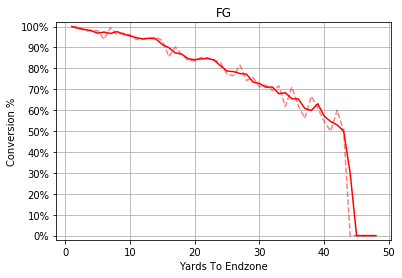

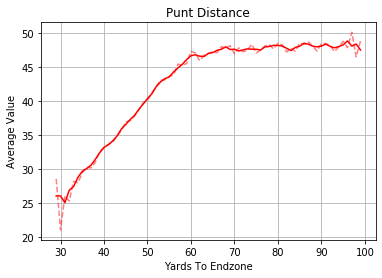

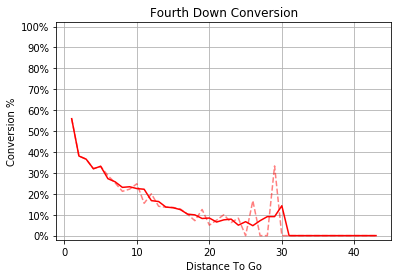

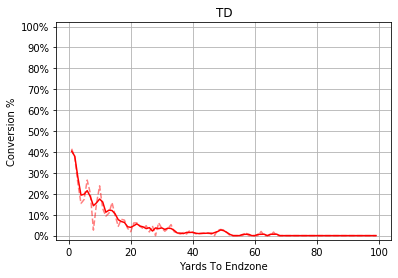

In [11]:
fg_smooth, fg_min, fg_max = smooth_and_graph(fg, 0, "rate", "Yards To Endzone", "FG")
punt_smooth, punt_min, punt_max = smooth_and_graph(punt, 0, "value", "Yards To Endzone", "Punt Distance")
convert_smooth, convert_min, convert_max = smooth_and_graph(convert, 5, "rate", "Distance To Go", "Fourth Down Conversion")
td_smooth, td_min, td_max = smooth_and_graph(td, 0, "rate", "Yards To Endzone", "TD")

# Calculate Expected Win Probability Added (EWPA) Using Multinomial Logistic WP Model

In [12]:
# load WP model
WP_model = pickle.load(open("Models/multinomial_WP_model.sav", "rb"))

In [13]:
EWPA_of_each_call, call_EWPA, call_vs_best_EWPA, prob_make_fg, pred_punt_dist, prob_convert_no_td, prob_td, EWPs = [], [], [], [], [], [], [], [] # call_EWPA represents EWPA based on play call to kick, punt or go

for index, row in data.iterrows():
    time, time_in_half, yrdline100, ydstogo, score_diff, total_score, is_home_team, pos_timeouts, def_timeouts, WP_before_play = int(row["TimeSecs"]), int(row["time_remaining_in_half"]), int(row["yrdline100"]), int(row["ydstogo"]), int(row["ScoreDiff"]), int(row["total_score"]), int(row["is_home_team"]), int(row["pos_timeouts"]), int(row["def_timeouts"]), row["aaron_multinomial_WP"]

    fg_made_prob = 0
    if yrdline100 >= fg_min and yrdline100 <= 45: # 45 instead of fg_max
        fg_made_prob = fg_smooth[yrdline100]
        
    punt_dist = 0
    if yrdline100 >= punt_min and yrdline100 <= punt_max:
        punt_dist = punt_smooth[yrdline100]
        
    # USING CONVERSION RATES FROM THIS ARTICLE http://www.advancedfootballanalytics.com/index.php/home/research/game-strategy/120-4th-down-study
    # INSTEAD OF FROM ABOVE FINDINGS BECAUSE IN ORIGINAL PROJECT I HAD NOT CALCULATED RATE AND DISTANCE CURVEs MYSELF
#     convert_prob = 0
#     if ydstogo >= convert_min and ydstogo <= 30: # 30 instead of convert_max
#         convert_prob = convert_smooth[ydstogo]
    if ydstogo == 1:
        convert_prob = 0.7
    elif ydstogo >= 2 and ydstogo <= 15:
        convert_prob = 0.66 - (ydstogo * 0.03)
    else:
        convert_prob = 0.1

    td_prob = 0
    if yrdline100 >= td_min and yrdline100 <= td_max:
        td_prob = td_smooth[yrdline100]
    convert_no_td_prob = max(convert_prob - td_prob, 0) # shouldn't be any cases below 0, but models are independent so just being safe

    # field goal EWPA
    # WP_x_variables = ["TimeSecs", "yrdline100", "ydstogo", "is_first_down", "is_second_down", "is_third_down", "is_fourth_down", "ScoreDiff", "total_score", "is_home_team", "pos_timeouts", "def_timeouts"]
    WP_made_fg_row_x = [[time-min(15, time_in_half), 75, 10, 1, 0, 0, 0, -(score_diff+3), total_score+3, 1-is_home_team, def_timeouts, pos_timeouts, 1]] # min(15,time_in_half): if there are less than 15 seconds left in the half, cut time down to exactly 0. last list element (1) is a constant
    made_fg_win_mdl_preds = WP_model.predict(WP_made_fg_row_x)[0] # outputs are probability of loss, tie, win
    fg_made_EWP = sum([v*p for v, p in zip([1,0.5,0], made_fg_win_mdl_preds)]) # [1,0.5,0] because calculating WP of other team starting with ball after kickoff
    fg_made_EWPA = fg_made_EWP - WP_before_play
    
    WP_missed_fg_row_x = [[time-min(15, time_in_half), 100-(yrdline100+7), 10, 1, 0, 0, 0, -score_diff, total_score, 1-is_home_team, def_timeouts, pos_timeouts, 1]]
    missed_fg_win_mdl_preds = WP_model.predict(WP_missed_fg_row_x)[0]
    fg_missed_EWP = sum([v*p for v, p in zip([1,0.5,0], missed_fg_win_mdl_preds)]) 
    fg_missed_EWPA = fg_missed_EWP - WP_before_play
    
    fg_call_EWPA = (fg_made_prob * fg_made_EWPA) + ((1 - fg_made_prob) * fg_missed_EWPA)

    # punt EWPA
    WP_punt_row_x = [[time-min(30, time_in_half), (100-yrdline100)+punt_dist, 10, 1, 0, 0, 0, -score_diff, total_score, 1-is_home_team, def_timeouts, pos_timeouts, 1]] # take off 30 seconds
    punt_win_mdl_preds = WP_model.predict(WP_punt_row_x)[0]
    punt_EWP = sum([v*p for v, p in zip([1,0.5,0],punt_win_mdl_preds)]) 
    punt_EWPA = punt_EWP - WP_before_play

    # go for it EWPA
    WP_convert_no_td_row_x = [[time-min(8, time_in_half), yrdline100-ydstogo, 10, 1, 0, 0, 0, score_diff, total_score, is_home_team, pos_timeouts, def_timeouts, 1]] # assuming they got exact yardage needed to convert (if not TD - TD treated as seperate case) and took 8 seconds
    convert_no_td_win_mdl_preds = WP_model.predict(WP_convert_no_td_row_x)[0]
    convert_no_td_EWP = sum([v*p for v, p in zip([0,0.5,1], convert_no_td_win_mdl_preds)]) 
    convert_no_td_EWPA = convert_no_td_EWP - WP_before_play
    
    WP_td_row_x = [[time-min(12, time_in_half), 75, 10, 1, 0, 0, 0, -(score_diff+7), total_score+7, 1-is_home_team, def_timeouts, pos_timeouts, 1]] # assuming play took 12 seconds, they made extra point and opponent is starting at their own 25
    td_win_mdl_preds = WP_model.predict(WP_td_row_x)[0]
    td_EWP = sum([v*p for v, p in zip([1,0.5,0], td_win_mdl_preds)]) 
    td_EWPA = td_EWP - WP_before_play
    
    WP_failed_convert_row_x = [[time-min(5, time_in_half), 100-yrdline100, 10, 1, 0, 0, 0, -score_diff, total_score, 1-is_home_team, def_timeouts, pos_timeouts, 1]] # only takes 5 seconds, no yardage gained
    failed_convert_win_mdl_preds = WP_model.predict(WP_failed_convert_row_x)[0]
    failed_convert_EWP = sum([v*p for v, p in zip([1,0.5,0], failed_convert_win_mdl_preds)]) 
    failed_convert_EWPA = failed_convert_EWP - WP_before_play
    
    go_for_call_EWPA = (convert_no_td_prob * convert_no_td_EWPA) + (td_prob * td_EWPA) + ((1 - convert_prob) * failed_convert_EWPA)

    # best option
    EWPA_call_options = [fg_call_EWPA, punt_EWPA, go_for_call_EWPA]
    best_call_EWPA = max(EWPA_call_options)

    # get EWPA of coach"s actual call
    if row["fourth_down_play_type"] == 0:
        actual_call_EWPA = fg_call_EWPA
    elif row["fourth_down_play_type"] == 1:
        actual_call_EWPA = punt_EWPA
    else:
        actual_call_EWPA = go_for_call_EWPA

    call_EWPA.append(actual_call_EWPA)
    call_vs_best_EWPA.append(actual_call_EWPA - best_call_EWPA)
    prob_make_fg.append(fg_made_prob)
    pred_punt_dist.append(punt_dist)
    prob_convert_no_td.append(convert_no_td_prob)
    prob_td.append(td_prob)
    EWPA_of_each_call.append(EWPA_call_options)
    EWPs.append([fg_made_EWP, fg_missed_EWP, punt_EWP, convert_no_td_EWP, td_EWP, failed_convert_EWP])
    
    if index % 5000 == 0:
        print("EWPA: " + str(index) + "/" + str(max(data.index)))

data["prob_make_fg"], data["pred_punt_dist"], data["prob_convert_no_td"], data["prob_td"], data["EWPA_of_each_call"], data["call_EWPA"], data["call_vs_best_EWPA"], data["EWPs"] = prob_make_fg, pred_punt_dist, prob_convert_no_td, prob_td, EWPA_of_each_call, call_EWPA, call_vs_best_EWPA, EWPs

print("EWPA done")

EWPA: 0/35902
EWPA: 5000/35902
EWPA: 10000/35902
EWPA: 15000/35902
EWPA: 20000/35902
EWPA: 25000/35902
EWPA: 30000/35902
EWPA: 35000/35902
EWPA done


Calculating team execution given play-call.

In [14]:
# data["WPA_execution_given_call"] = data.apply(lambda row: row["aaron_multinomial_WPA"] - row["call_EWPA"], axis=1)
data["WPA_execution_given_call"] = data["aaron_multinomial_WPA"] - data["call_EWPA"]

# Save Data

In [15]:
data.to_csv("fourth_down_EWPA.csv", encoding="utf-8", index=False)

# MODEL EVALUATION

# Test EWPA Model Accuracy
Test model on 2015-2017 seasons.
Field goal probability, punt distance, conversion probability, and touchdown probability models all built including 2015-2017 data, which that may cause statistical bias. However, I believe this bias will be negligible.

In [16]:
# data = pd.read_csv("fourth_down_EWPA.csv")
test_data = data[data["Season"] >= 2015]

Remove fake punts and field goals

In [17]:
punt_fg_formations = test_data[test_data["desc"].str.contains("Punt formation|Field Goal formation")]
fakes = punt_fg_formations[((punt_fg_formations["Passer_ID"] != "None") | (punt_fg_formations["Rusher_ID"] != "None")) & ~(punt_fg_formations["desc"].str.contains("Aborted"))]
test_data = test_data[test_data.apply(lambda x: x.values.tolist() not in fakes.values.tolist(), axis=1)]

In [18]:
# https://stackoverflow.com/questions/2130016/splitting-a-list-into-n-parts-of-approximately-equal-length/37414115
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
        
    return out

In [19]:
num_buckets = 50
chunked_data = chunkIt(sorted(data["call_EWPA"]), num_buckets)
prediction_intervals = [[i[0],i[-1]] for i in chunked_data]

bucket_id = []
for i in data["call_EWPA"]:
    for j in range(len(prediction_intervals)):
        if prediction_intervals[j][0] <= i <= prediction_intervals[j][1]:
            bucket_id.append(j)
            break # so if one play fits into two buckets we only place it in one

data["bucket_id"] = bucket_id

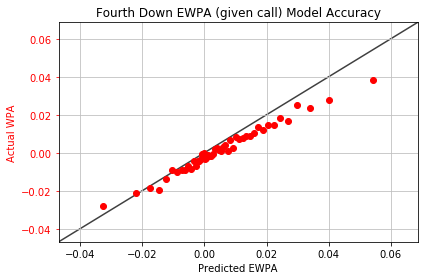

Correlation between Fourth Down EWPA and Actual WPA: 0.9905426272598576


In [20]:
predicted_bucket_values = [[] for _ in range(len(list(set(bucket_id))))]
actual_bucket_values = [[] for _ in range(len(list(set(bucket_id))))]
for index, row in data.iterrows():
    predicted_bucket_values[row["bucket_id"]].append(row["call_EWPA"])
    actual_bucket_values[row["bucket_id"]].append(row["aaron_multinomial_WPA"])

predicted_bucket_means = []
for i in range(len(predicted_bucket_values)):
    predicted_bucket_means.append(np.mean(predicted_bucket_values[i]))
actual_bucket_means = []
for i in range(len(actual_bucket_values)):
    actual_bucket_means.append(np.mean(actual_bucket_values[i]))

fig, ax1 = plt.subplots()
x1 = predicted_bucket_means
y1 = actual_bucket_means
ax1.plot(x1, y1, "ro")
limlo, limhi = ax1.get_xlim()[0]-0.01, ax1.get_xlim()[1]+0.01
ax1.set_xlim(limlo, limhi)
ax1.set_ylim(limlo, limhi)
ax1.plot([limlo, limhi], [limlo, limhi], "k-", alpha=0.75, zorder=0)
ax1.set_title("Fourth Down EWPA (given call) Model Accuracy")
ax1.set_xlabel("Predicted EWPA")
ax1.set_ylabel("Actual WPA", color="r")
ax1.tick_params("y", colors="r")
ax1.grid(True, linestyle="-", color="0.75")

fig.tight_layout()
plt.show()

print("Correlation between Fourth Down EWPA and Actual WPA: " + str(np.corrcoef(x1,y1)[0][1]))